# **Modelo**

**INICIO PREPROCESAMIENTO**

In [ ]:
import pandas as pd
import numpy as np

# Importamos la información de la tabla Maestro Clientes.
df = pd.read_excel('base_de_datos_0.xlsx',na_values=["Null"])
print('Se leyo un dataset de dimensiones {}'.format(df.shape))
df.head()

Se leyo un dataset de dimensiones (1252, 19)


,FECHA_CORTE,ÁMBITO,UBIGEO,DEPARTAMENTO,PROVINCIA,DISTRITO,FECHA REPORTE,HECHO,MOTIVO,TIPO DE USUARIO,TIPO ATENCIÓN,SEXO REPORTANTE,GRUPOS POBLACIONALES,PERTENENCIA ÉTNICA REPORTANTE,AÑO REPORTE,MES REPORTE,CANAL DE ATENCIÓN,ESTADO DEL REPORTE,ID
0,20250206,Institución educativa,70101.0,Callao,Callao,Callao,NaT,Agresión verbal,NaN,NaN,NaN,NaN,NaN,NaN,2012,NaN,Plataforma Alerta Contra el Racismo,Atendido,1-2012-SO
1,20250206,Centro laboral,120101.0,Junín,Huancayo,Huancayo,NaT,Trato diferenciado o despectivo,NaN,NaN,NaN,NaN,NaN,NaN,2012,NaN,Plataforma Alerta Contra el Racismo,Atendido,2-2012-SO
2,20250206,Lugares de consumo,150131.0,Lima,Lima,San Isidro,NaT,"Restricción, limitación o condicionamiento de ...",NaN,NaN,NaN,NaN,NaN,NaN,2013,NaN,Plataforma Alerta Contra el Racismo,Atendido,3-2013-SO
3,20250206,Espacio público,60101.0,Cajamarca,Cajamarca,Cajamarca,NaT,Agresión verbal,NaN,NaN,NaN,NaN,NaN,NaN,2013,NaN,Plataforma Alerta Contra el Racismo,Atendido,4-2013-SO
4,20250206,Espacio público,150102.0,Lima,Lima,Ancon,NaT,"Restricción, limitación o condicionamiento de ...",NaN,NaN,NaN,NaN,NaN,NaN,2013,NaN,Plataforma Alerta Contra el Racismo,Atendido,5-2013-SO


In [ ]:
print("Dimensiones del DataFrame original:", df.shape)

# Conteo de nulos antes de dropna
print("\nConteo de valores nulos por columna (antes de dropna):")
print(df.isnull().sum())

# Número de filas que se eliminarían con dropna
num_filas_antes_dropna = df.shape[0]
df_despues_dropna = df.dropna()
num_filas_despues_dropna = df_despues_dropna.shape[0]
print(f"\nFilas antes de dropna(): {num_filas_antes_dropna}")
print(f"Filas después de dropna(): {num_filas_despues_dropna}")
print(f"Filas eliminadas por dropna(): {num_filas_antes_dropna - num_filas_despues_dropna}")

Dimensiones del DataFrame original: (1252, 19)

Conteo de valores nulos por columna (antes de dropna):
FECHA_CORTE                        0
ÁMBITO                             0
UBIGEO                            22
DEPARTAMENTO                       0
PROVINCIA                          0
DISTRITO                           0
FECHA REPORTE                    436
HECHO                              0
MOTIVO                           548
TIPO DE USUARIO                  451
TIPO ATENCIÓN                    436
SEXO REPORTANTE                  499
GRUPOS POBLACIONALES             676
PERTENENCIA ÉTNICA REPORTANTE    599
AÑO REPORTE                        0
MES REPORTE                       84
CANAL DE ATENCIÓN                  1
ESTADO DEL REPORTE                 0
ID                                 0
dtype: int64

Filas antes de dropna(): 1252
Filas después de dropna(): 517
Filas eliminadas por dropna(): 735


In [ ]:
# Eliminamos las columnas que no vamos a usar
df = df.drop(columns = ['UBIGEO','FECHA_CORTE','PROVINCIA','DISTRITO','FECHA REPORTE','TIPO ATENCIÓN','AÑO REPORTE','CANAL DE ATENCIÓN','ID'])

print("\nDimensiones del DataFrame después de eliminar columnas no usadas:", df.shape)
print("Conteo de valores nulos por columna (después de eliminar columnas no usadas):")
print(df.isnull().sum())


Dimensiones del DataFrame después de eliminar columnas no usadas: (1252, 10)
Conteo de valores nulos por columna (después de eliminar columnas no usadas):
ÁMBITO                             0
DEPARTAMENTO                       0
HECHO                              0
MOTIVO                           548
TIPO DE USUARIO                  451
SEXO REPORTANTE                  499
GRUPOS POBLACIONALES             676
PERTENENCIA ÉTNICA REPORTANTE    599
MES REPORTE                       84
ESTADO DEL REPORTE                 0
dtype: int64


In [ ]:
# --- PASO 2: Manejo de nulos de forma más selectiva ---

# Estrategia:
# 1. Eliminar columnas con un porcentaje MUY ALTO de nulos si no se consideran informativas.
#    Consideraremos que más del 50% de nulos es un umbral para considerar la eliminación
#    si el dominio no indica una fuerte importancia o una forma clara de imputar.
#    GRUPOS POBLACIONALES (676 nulos / 1252 = ~54%)
#    PERTENENCIA ÉTNICA REPORTANTE (599 nulos / 1252 = ~48%) -> Esta está cerca, la mantendremos y la imputaremos.

# Eliminamos 'GRUPOS POBLACIONALES' debido a su alto porcentaje de nulos.
if 'GRUPOS POBLACIONALES' in df.columns:
    df = df.drop(columns=['GRUPOS POBLACIONALES'])
    print("\nColumna 'GRUPOS POBLACIONALES' eliminada debido a su alto porcentaje de nulos.")


# 2. Imputar nulos en columnas categóricas con un valor 'Desconocido'.
#    Esto es útil para que el modelo sepa que hay una categoría de "información faltante".
#    Aplica a: MOTIVO, TIPO DE USUARIO, SEXO REPORTANTE, PERTENENCIA ÉTNICA REPORTANTE.
print("\nImputando valores nulos en columnas categóricas con 'Desconocido'...")
for col in ['MOTIVO', 'TIPO DE USUARIO', 'SEXO REPORTANTE', 'PERTENENCIA ÉTNICA REPORTANTE']:
    if col in df.columns: # Verificar si la columna existe antes de imputar
        df[col] = df[col].fillna('Desconocido')


# 3. Imputar nulos en 'MES REPORTE'.
#    Como es una variable que mapearás a numérica y luego cíclica,
#    la imputación es importante. Podríamos imputarla con la moda (el mes más frecuente)
#    o con un valor específico si hay un significado para 'mes desconocido'.
#    Para este caso, imputaremos con la moda (el valor más frecuente), ya que es una variable con menos nulos
#    y que tiene un patrón cíclico importante.
print("\nImputando valores nulos en 'MES REPORTE' con la moda...")
if 'MES REPORTE' in df.columns:
    moda_mes_reporte = df['MES REPORTE'].mode()[0]
    df['MES REPORTE'] = df['MES REPORTE'].fillna(moda_mes_reporte)


# Verificar el estado final de los nulos y las dimensiones
print("\nConteo FINAL de valores nulos por columna después de imputaciones:")
print(df.isnull().sum())

print("\nDimensiones finales del DataFrame después del manejo de nulos:", df.shape)


Columna 'GRUPOS POBLACIONALES' eliminada debido a su alto porcentaje de nulos.

Imputando valores nulos en columnas categóricas con 'Desconocido'...

Imputando valores nulos en 'MES REPORTE' con la moda...

Conteo FINAL de valores nulos por columna después de imputaciones:
ÁMBITO                           0
DEPARTAMENTO                     0
HECHO                            0
MOTIVO                           0
TIPO DE USUARIO                  0
SEXO REPORTANTE                  0
PERTENENCIA ÉTNICA REPORTANTE    0
MES REPORTE                      0
ESTADO DEL REPORTE               0
dtype: int64

Dimensiones finales del DataFrame después del manejo de nulos: (1252, 9)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Valores únicos y su conteo en 'ESTADO DEL REPORTE' antes del mapeo:")
print(df['ESTADO DEL REPORTE'].value_counts())

# Mapear 'ESTADO DEL REPORTE' a valores numéricos (0 y 1)
# Basado en el informe, "Atendido" es el estado de resolución favorable.
df['ESTADO DEL REPORTE'] = np.where(df['ESTADO DEL REPORTE'] == 'Atendido', 1, 0)

print("\nValores únicos y su conteo en 'ESTADO DEL REPORTE' después del mapeo:")
print(df['ESTADO DEL REPORTE'].value_counts())

# Ahora, con ESTADO DEL REPORTE numérico, podemos ejecutar el análisis por DEPARTAMENTO.

print("\nTasa promedio de 'ESTADO DEL REPORTE' por DEPARTAMENTO original:")
departamento_atencion_rate = df.groupby('DEPARTAMENTO')['ESTADO DEL REPORTE'].mean().sort_values(ascending=False)
print(departamento_atencion_rate.to_string())

print("\nConteo de registros por DEPARTAMENTO original:")
departamento_counts = df['DEPARTAMENTO'].value_counts()
print(departamento_counts.to_string())

Valores únicos y su conteo en 'ESTADO DEL REPORTE' antes del mapeo:
ESTADO DEL REPORTE
Atendido       1073
En revisión      99
Seguimiento      41
Archivado        25
Observado        14
Name: count, dtype: int64

Valores únicos y su conteo en 'ESTADO DEL REPORTE' después del mapeo:
ESTADO DEL REPORTE
1    1073
0     179
Name: count, dtype: int64

Tasa promedio de 'ESTADO DEL REPORTE' por DEPARTAMENTO original:
DEPARTAMENTO
Lambayeque       1.00
Ucayali          1.00
Puno             1.00
Pasco            1.00
San Martín       1.00
Tumbes           1.00
La Libertad      0.93
Ayacucho         0.90
Callao           0.89
Piura            0.88
Lima             0.87
Ancash           0.86
Cusco            0.84
Tacna            0.83
Madre de Dios    0.83
Amazonas         0.82
Arequipa         0.79
Apurímac         0.78
Ica              0.78
Huánuco          0.75
Cajamarca        0.73
Loreto           0.71
Junín            0.68
Huancavelica     0.67
Moquegua         0.50

Conteo de registros p

In [ ]:
# Codificamos Departamento
df['LIMA'] = np.where(df.DEPARTAMENTO == 'Lima', 1, 0)
df['SUR'] = np.where(df.DEPARTAMENTO.isin(['Arequipa', 'Cusco', 'Ica', 'Apurímac', 'Ayacucho', 'Tacna', 'Huancavelica', 'Madre de Dios', 'Puno', 'Moquegua']), 1, 0)
df['CENTRO'] = np.where(df.DEPARTAMENTO.isin(['Callao', 'Huánuco', 'Junin', 'San Martín', 'Pasco', 'Ucayali']), 1, 0)
df['NORTE'] = np.where(df.DEPARTAMENTO.isin(['Piura', 'Cajamarca', 'La Libertad', 'Loreto', 'Ancash', 'Tumbes', 'Lambayeque']), 1, 0)

df = df.drop(columns = ['DEPARTAMENTO'])

print("\nPrimeras 5 filas del DataFrame con las nuevas columnas de región:")
print(df.head())

print("\nÚltimas 5 filas del DataFrame con las nuevas columnas de región:")
print(df.tail())

print("\nDimensiones del DataFrame después de codificar DEPARTAMENTO:", df.shape)


Primeras 5 filas del DataFrame con las nuevas columnas de región:
                  ÁMBITO                                              HECHO       MOTIVO TIPO DE USUARIO SEXO REPORTANTE PERTENENCIA ÉTNICA REPORTANTE MES REPORTE  ESTADO DEL REPORTE  LIMA  SUR  CENTRO  NORTE
0  Institución educativa                                    Agresión verbal  Desconocido     Desconocido     Desconocido                   Desconocido       Abril                   1     0    0       1      0
1         Centro laboral                    Trato diferenciado o despectivo  Desconocido     Desconocido     Desconocido                   Desconocido       Abril                   1     0    0       0      0
2     Lugares de consumo  Restricción, limitación o condicionamiento de ...  Desconocido     Desconocido     Desconocido                   Desconocido       Abril                   1     1    0       0      0
3        Espacio público                                    Agresión verbal  Desconocido     Desc

In [ ]:
print("Valores únicos y su conteo en 'ÁMBITO' antes del mapeo:")
print(df['ÁMBITO'].value_counts().to_string())

print("\nTasa promedio de 'ESTADO DEL REPORTE' por 'ÁMBITO' original:")
ambito_atencion_rate = df.groupby('ÁMBITO')['ESTADO DEL REPORTE'].mean().sort_values(ascending=False)
print(ambito_atencion_rate.to_string())

Valores únicos y su conteo en 'ÁMBITO' antes del mapeo:
ÁMBITO
Lugares de consumo                   237
Otros                                232
Espacio público                      220
Internet                             206
Centro laboral                        94
Institución pública                   94
Medio de comunicación                 68
Institución educativa                 67
Establecimiento de salud              18
Espectáculo o actividad deportiva     14
Establecimiento de Salud               2

Tasa promedio de 'ESTADO DEL REPORTE' por 'ÁMBITO' original:
ÁMBITO
Establecimiento de Salud             1.00
Medio de comunicación                0.94
Lugares de consumo                   0.90
Centro laboral                       0.89
Otros                                0.88
Espacio público                      0.87
Internet                             0.83
Institución educativa                0.81
Establecimiento de salud             0.78
Espectáculo o actividad deportiva    0.

In [ ]:
# --- Corrección de duplicación en ÁMBITO ---
# Unificamos 'Establecimiento de Salud' (con mayúscula) a 'Establecimiento de salud' (con minúscula)
df['ÁMBITO'] = df['ÁMBITO'].replace('Establecimiento de Salud', 'Establecimiento de salud')
print("Valores únicos y su conteo en 'ÁMBITO' DESPUÉS de la corrección de duplicación:")
print(df['ÁMBITO'].value_counts().to_string())


# --- Codificamos Ámbito  ---
df['CERRADO'] = np.where(df['ÁMBITO'].isin(['Lugares de consumo','Institución pública','Centro laboral','Institución educativa','Establecimiento de salud']), 1, 0)
df['ABIERTO'] = np.where(df['ÁMBITO'].isin(['Espacio público','Espectáculo o actividad deportiva']), 1, 0)
df['DIGITAL'] = np.where(df['ÁMBITO'].isin(['Internet','Medio de comunicación']), 1, 0)
df['OTRO_AMBITO'] = np.where(df['ÁMBITO'].isin(['Otros']), 1, 0)

df = df.drop(columns = ['ÁMBITO'])

print("\nPrimeras 5 filas del DataFrame con las nuevas columnas de ámbito:")
print(df.head())

print("\nÚltimas 5 filas del DataFrame con las nuevas columnas de ámbito:")
print(df.tail())

print("\nDimensiones del DataFrame después de codificar ÁMBITO:", df.shape)

Valores únicos y su conteo en 'ÁMBITO' DESPUÉS de la corrección de duplicación:
ÁMBITO
Lugares de consumo                   237
Otros                                232
Espacio público                      220
Internet                             206
Institución pública                   94
Centro laboral                        94
Medio de comunicación                 68
Institución educativa                 67
Establecimiento de salud              20
Espectáculo o actividad deportiva     14

Primeras 5 filas del DataFrame con las nuevas columnas de ámbito:
                                               HECHO       MOTIVO TIPO DE USUARIO SEXO REPORTANTE PERTENENCIA ÉTNICA REPORTANTE MES REPORTE  ESTADO DEL REPORTE  LIMA  SUR  CENTRO  NORTE  CERRADO  ABIERTO  DIGITAL  OTRO_AMBITO
0                                    Agresión verbal  Desconocido     Desconocido     Desconocido                   Desconocido       Abril                   1     0    0       1      0        1        0       

In [ ]:
print("Valores únicos y su conteo en 'HECHO' antes del mapeo:")
print(df['HECHO'].value_counts().to_string())

print("\nTasa promedio de 'ESTADO DEL REPORTE' por 'HECHO' original:")
hecho_atencion_rate = df.groupby('HECHO')['ESTADO DEL REPORTE'].mean().sort_values(ascending=False)
print(hecho_atencion_rate.to_string())

Valores únicos y su conteo en 'HECHO' antes del mapeo:
HECHO
Agresión verbal                                                              519
Trato diferenciado o despectivo                                              412
Restricción, limitación o condicionamiento de acceso a un bien o servicio    266
Agresión física                                                               38
Negativa a ser atendido                                                       16
Impedimento expresiones culturales                                             1

Tasa promedio de 'ESTADO DEL REPORTE' por 'HECHO' original:
HECHO
Impedimento expresiones culturales                                           1.00
Trato diferenciado o despectivo                                              0.92
Agresión verbal                                                              0.84
Restricción, limitación o condicionamiento de acceso a un bien o servicio    0.82
Agresión física                                           

In [ ]:
print(df['HECHO'].value_counts())

HECHO
Agresión verbal                                                              519
Trato diferenciado o despectivo                                              412
Restricción, limitación o condicionamiento de acceso a un bien o servicio    266
Agresión física                                                               38
Negativa a ser atendido                                                       16
Impedimento expresiones culturales                                             1
Name: count, dtype: int64


In [ ]:
# --- Nueva estrategia de codificación para HECHO ---

# 1. Crear una categoría para "BAJA ATENCIÓN"
#    Agrupamos 'Negativa a ser atendido' por su tasa de atención significativamente más baja.
df['HECHO_BAJA_ATENCION'] = np.where(df['HECHO'] == 'Negativa a ser atendido', 1, 0)

# 2. Agrupación para "AGRESIÓN"
#    'Agresión verbal' (0.84) y 'Agresión física' (0.79)
df['HECHO_AGRESION'] = np.where(df['HECHO'].isin(['Agresión verbal','Agresión física']), 1, 0)

# 3. Agrupación para "RESTRICCION_O_TRATO_DIFERENCIADO"
#    Agrupamos 'Restricción, limitación o condicionamiento de acceso a un bien o servicio' (0.82)
#    y 'Trato diferenciado o despectivo' (0.92). Si bien hay una diferencia,
#    ambas son altas y representan "discriminación" o "trato desigual".
df['HECHO_RESTRICCION_TRATO'] = np.where(df['HECHO'].isin(['Restricción, limitación o condicionamiento de acceso a un bien o servicio','Trato diferenciado o despectivo']), 1, 0)

# 4. Manejar el caso de "Impedimento expresiones culturales" (1 solo registro)
#    Dado que solo tiene un registro, es mejor no crear una columna binaria separada para él.
#    Podemos dejarlo "no cubierto" por las columnas binarias anteriores.
#    Si no está cubierto por ninguna de las anteriores, sus valores en las nuevas columnas serán 0.
#    Alternativamente, si el problema tuviera una categoría "Otros" real para HECHO,
#    podríamos haberlo incluido allí, pero en este caso, al ser tan único, no lo agrupamos.

# Verificamos que al menos un 1 sea verdadero en cada fila para asegurar que no nos dejamos nada
# exceptuando el caso del "Impedimento expresiones culturales"

# Eliminamos la columna 'HECHO' original
df = df.drop(columns = ['HECHO'])

print("\nPrimeras 5 filas del DataFrame con las nuevas columnas de hecho:")
print(df.head())

print("\nÚltimas 5 filas del DataFrame con las nuevas columnas de hecho:")
print(df.tail())

print("\nDimensiones del DataFrame después de la nueva codificación de HECHO:", df.shape)


Primeras 5 filas del DataFrame con las nuevas columnas de hecho:
        MOTIVO TIPO DE USUARIO SEXO REPORTANTE PERTENENCIA ÉTNICA REPORTANTE MES REPORTE  ESTADO DEL REPORTE  LIMA  SUR  CENTRO  NORTE  CERRADO  ABIERTO  DIGITAL  OTRO_AMBITO  HECHO_BAJA_ATENCION  HECHO_AGRESION  HECHO_RESTRICCION_TRATO
0  Desconocido     Desconocido     Desconocido                   Desconocido       Abril                   1     0    0       1      0        1        0        0            0                    0               1                        0
1  Desconocido     Desconocido     Desconocido                   Desconocido       Abril                   1     0    0       0      0        1        0        0            0                    0               0                        1
2  Desconocido     Desconocido     Desconocido                   Desconocido       Abril                   1     1    0       0      0        1        0        0            0                    0               0            

In [ ]:
print("Valores únicos y su conteo en 'MOTIVO' ANTES de cualquier split o eliminación:")
print(df['MOTIVO'].value_counts().to_string())

print("\nTasa promedio de 'ESTADO DEL REPORTE' por 'MOTIVO' original:")
motivo_atencion_rate = df.groupby('MOTIVO')['ESTADO DEL REPORTE'].mean().sort_values(ascending=False)
print(motivo_atencion_rate.to_string())

# --- **MUY IMPORTANTE**: Prueba el split y limpieza SIN ELIMINAR FILAS AÚN ---
# Creamos una copia temporal para ver los resultados del split
df_temp = df.copy()

# Se separan los motivos (como en tu código)
df_temp[['MOTIVO_1', 'MOTIVO_2']] = df_temp['MOTIVO'].str.split(r'[,.]', n=1, expand=True)

# Se reemplaza 'Otro' por None en MOTIVO_2 si existe
# Ajuste para manejar None antes de strip/capitalize
df_temp['MOTIVO_2'] = df_temp['MOTIVO_2'].apply(lambda x: x.strip().capitalize() if isinstance(x, str) else x)
df_temp['MOTIVO_2'] = df_temp['MOTIVO_2'].replace('Otro', None)

# Se corrigen valores que estaban mal escritos en MOTIVO_1
reemplazos = {
    'Rasgos faciales o fìsicos': 'Rasgos faciales o físicos',
    'Lugar de origen': 'Lugar de procedencia',
    'Idioma o lengua': 'Idioma o lengua que habla'
}
df_temp['MOTIVO_1'] = df_temp['MOTIVO_1'].replace(reemplazos)

print("\n--- Vista previa de MOTIVO_1 y MOTIVO_2 después del split y limpieza (en copia temporal) ---")
print("Conteo de valores únicos en MOTIVO_1 (después del split y correcciones, antes de eliminar filas):")
print(df_temp['MOTIVO_1'].value_counts().to_string())

print("\nConteo de valores únicos en MOTIVO_2 (después del split y limpieza, antes de eliminar filas):")
print(df_temp['MOTIVO_2'].value_counts(dropna=False).to_string())

# Evaluar cuántas filas se eliminarían
num_rows_before_drop = df_temp.shape[0]
num_rows_after_otro = df_temp[df_temp['MOTIVO_1'] != 'Otro'].shape[0]
num_rows_after_condicion = df_temp[df_temp['MOTIVO_1'] != 'Condición económica'].shape[0]
num_rows_after_all_drops = df_temp[(df_temp['MOTIVO_1'] != 'Otro') & (df_temp['MOTIVO_1'] != 'Condición económica')].shape[0]

print(f"\nNúmero total de filas: {num_rows_before_drop}")
print(f"Filas si eliminamos 'Otro' de MOTIVO_1: {num_rows_after_otro}")
print(f"Filas si eliminamos 'Condición económica' de MOTIVO_1: {num_rows_after_condicion}")
print(f"Filas si eliminamos 'Otro' y 'Condición económica' de MOTIVO_1: {num_rows_after_all_drops}")
print(f"Total de filas a eliminar: {num_rows_before_drop - num_rows_after_all_drops}")

Valores únicos y su conteo en 'MOTIVO' ANTES de cualquier split o eliminación:
MOTIVO
Desconocido                                             548
Lugar de procedencia                                    126
Otro                                                    101
Color de piel, Rasgos faciales o físicos                 91
Color de piel                                            62
Rasgos faciales o físicos                                43
Rasgos faciales o físicos, Lugar de procedencia          32
Rasgos faciales o físicos, Vestimenta                    27
Color de piel, Lugar de procedencia                      25
Lugar de procedencia, Forma de hablar                    24
Color de piel, Vestimenta                                20
Vestimenta                                               17
Lugar de procedencia, Idioma o lengua que habla          17
Lugar de procedencia, Costumbres                         12
Forma de hablar                                          11
Idioma o lengu

In [ ]:
# n=1 asegura que solo se realice un split, resultando en máximo dos partes
df[['MOTIVO_1', 'MOTIVO_2']] = df['MOTIVO'].str.split(r'[,.]', n=1, expand=True)

# Se elimina la columna MOTIVO original
df = df.drop(columns = ['MOTIVO'])

# Procesamiento de MOTIVO_2
# Aplica strip() y capitalize() solo si el valor es un string (para manejar Nones correctamente)
# Esto limpia el texto y asegura que "Otro" se capitalice correctamente antes del reemplazo si fuera el caso
df['MOTIVO_2'] = df['MOTIVO_2'].apply(lambda x: x.strip().capitalize() if isinstance(x, str) else x)
# Reemplazar "Otro" por None en MOTIVO_2 si existe después de capitalizar
# Esto es si el segundo motivo fuera "Otro" y queremos que sea nulo.
df['MOTIVO_2'] = df['MOTIVO_2'].replace("Otro", None)

# Se corrigen valores que estaban mal escritos en MOTIVO_1
reemplazos = {
    'Rasgos faciales o fìsicos': 'Rasgos faciales o físicos',
    'Lugar de origen': 'Lugar de procedencia',
    'Idioma o lengua': 'Idioma o lengua que habla'
}
df['MOTIVO_1'] = df['MOTIVO_1'].replace(reemplazos)

# *** IMPORTANTE: NO eliminamos las filas donde MOTIVO_1 es 'Otro' o 'Condición económica'.
# Estas se mantendrán como categorías válidas en MOTIVO_1. ***

print("\nPrimeras 5 filas del DataFrame con las nuevas columnas MOTIVO_1 y MOTIVO_2:")
print(df.head())

print("\nÚltimas 5 filas del DataFrame con las nuevas columnas MOTIVO_1 y MOTIVO_2:")
print(df.tail())

print("\nDimensiones del DataFrame después de procesar MOTIVO:", df.shape)

print("\nConteo de valores únicos en MOTIVO_1 (después del split y correcciones, SIN eliminar filas):")
print(df['MOTIVO_1'].value_counts().to_string())

print("\nConteo de valores únicos en MOTIVO_2 (después del split y limpieza, SIN eliminar filas):")
print(df['MOTIVO_2'].value_counts(dropna=False).to_string()) # dropna=False para ver los Nulos


Primeras 5 filas del DataFrame con las nuevas columnas MOTIVO_1 y MOTIVO_2:
  TIPO DE USUARIO SEXO REPORTANTE PERTENENCIA ÉTNICA REPORTANTE MES REPORTE  ESTADO DEL REPORTE  LIMA  SUR  CENTRO  NORTE  CERRADO  ABIERTO  DIGITAL  OTRO_AMBITO  HECHO_BAJA_ATENCION  HECHO_AGRESION  HECHO_RESTRICCION_TRATO     MOTIVO_1 MOTIVO_2
0     Desconocido     Desconocido                   Desconocido       Abril                   1     0    0       1      0        1        0        0            0                    0               1                        0  Desconocido     None
1     Desconocido     Desconocido                   Desconocido       Abril                   1     0    0       0      0        1        0        0            0                    0               0                        1  Desconocido     None
2     Desconocido     Desconocido                   Desconocido       Abril                   1     1    0       0      0        1        0        0            0                    0   

In [ ]:
print("\nTasa promedio de 'ESTADO DEL REPORTE' por 'MOTIVO_1':")
motivo1_atencion_rate = df.groupby('MOTIVO_1')['ESTADO DEL REPORTE'].mean().sort_values(ascending=False)
print(motivo1_atencion_rate.to_string())


Tasa promedio de 'ESTADO DEL REPORTE' por 'MOTIVO_1':
MOTIVO_1
Condición económica          1.00
Desconocido                  1.00
Vestimenta                   0.95
Otro                         0.82
Idioma o lengua que habla    0.80
Costumbres                   0.80
Rasgos faciales o físicos    0.79
Lugar de procedencia         0.75
Color de piel                0.67
Forma de hablar              0.65


In [ ]:
# Creamos columnas binarias para las categorías clave de MOTIVO_1
df['MOTIVO_1_DESCONOCIDO'] = np.where(df['MOTIVO_1'] == 'Desconocido', 1, 0)
df['MOTIVO_1_OTRO'] = np.where(df['MOTIVO_1'] == 'Otro', 1, 0)
df['MOTIVO_1_COLOR_PIEL'] = np.where(df['MOTIVO_1'] == 'Color de piel', 1, 0)
df['MOTIVO_1_FORMA_HABLAR'] = np.where(df['MOTIVO_1'] == 'Forma de hablar', 1, 0)
df['MOTIVO_1_LUGAR_PROCEDENCIA'] = np.where(df['MOTIVO_1'] == 'Lugar de procedencia', 1, 0)
df['MOTIVO_1_RASGOS_FISICOS'] = np.where(df['MOTIVO_1'] == 'Rasgos faciales o físicos', 1, 0)

# Eliminamos las columnas originales MOTIVO_1 y MOTIVO_2
df = df.drop(columns = ['MOTIVO_1', 'MOTIVO_2'])

print("\nPrimeras 5 filas del DataFrame con las nuevas columnas binarias de MOTIVO:")
print(df.head())

print("\nÚltimas 5 filas del DataFrame con las nuevas columnas binarias de MOTIVO:")
print(df.tail())

print("\nDimensiones del DataFrame después de la nueva codificación de MOTIVO:", df.shape)


Primeras 5 filas del DataFrame con las nuevas columnas binarias de MOTIVO:
  TIPO DE USUARIO SEXO REPORTANTE PERTENENCIA ÉTNICA REPORTANTE MES REPORTE  ESTADO DEL REPORTE  LIMA  SUR  CENTRO  NORTE  CERRADO  ABIERTO  DIGITAL  OTRO_AMBITO  HECHO_BAJA_ATENCION  HECHO_AGRESION  HECHO_RESTRICCION_TRATO  MOTIVO_1_DESCONOCIDO  MOTIVO_1_OTRO  MOTIVO_1_COLOR_PIEL  MOTIVO_1_FORMA_HABLAR  MOTIVO_1_LUGAR_PROCEDENCIA  MOTIVO_1_RASGOS_FISICOS
0     Desconocido     Desconocido                   Desconocido       Abril                   1     0    0       1      0        1        0        0            0                    0               1                        0                     1              0                    0                      0                           0                        0
1     Desconocido     Desconocido                   Desconocido       Abril                   1     0    0       0      0        1        0        0            0                    0               0          

In [ ]:
print("Valores únicos y su conteo en 'TIPO DE USUARIO' antes del mapeo:")
print(df['TIPO DE USUARIO'].value_counts().to_string())

print("\nTasa promedio de 'ESTADO DEL REPORTE' por 'TIPO DE USUARIO' original:")
tipo_usuario_atencion_rate = df.groupby('TIPO DE USUARIO')['ESTADO DEL REPORTE'].mean().sort_values(ascending=False)
print(tipo_usuario_atencion_rate.to_string())

Valores únicos y su conteo en 'TIPO DE USUARIO' antes del mapeo:
TIPO DE USUARIO
Víctima        693
Desconocido    451
Testigo        108

Tasa promedio de 'ESTADO DEL REPORTE' por 'TIPO DE USUARIO' original:
TIPO DE USUARIO
Desconocido    0.99
Víctima        0.78
Testigo        0.76


In [ ]:
# Codificamos TIPO DE USUARIO con dos columnas binarias
df['USUARIO_VICTIMA'] = np.where(df['TIPO DE USUARIO'] == 'Víctima', 1, 0)
df['USUARIO_DESCONOCIDO'] = np.where(df['TIPO DE USUARIO'] == 'Desconocido', 1, 0)

# Eliminamos la columna original 'TIPO DE USUARIO'
df = df.drop(columns = ['TIPO DE USUARIO'])

print("\nPrimeras 5 filas del DataFrame con las nuevas columnas binarias de TIPO DE USUARIO:")
print(df.head())

print("\nÚltimas 5 filas del DataFrame con las nuevas columnas binarias de TIPO DE USUARIO:")
print(df.tail())

print("\nDimensiones del DataFrame después de codificar TIPO DE USUARIO:", df.shape)


Primeras 5 filas del DataFrame con las nuevas columnas binarias de TIPO DE USUARIO:
  SEXO REPORTANTE PERTENENCIA ÉTNICA REPORTANTE MES REPORTE  ESTADO DEL REPORTE  LIMA  SUR  CENTRO  NORTE  CERRADO  ABIERTO  DIGITAL  OTRO_AMBITO  HECHO_BAJA_ATENCION  HECHO_AGRESION  HECHO_RESTRICCION_TRATO  MOTIVO_1_DESCONOCIDO  MOTIVO_1_OTRO  MOTIVO_1_COLOR_PIEL  MOTIVO_1_FORMA_HABLAR  MOTIVO_1_LUGAR_PROCEDENCIA  MOTIVO_1_RASGOS_FISICOS  USUARIO_VICTIMA  USUARIO_DESCONOCIDO
0     Desconocido                   Desconocido       Abril                   1     0    0       1      0        1        0        0            0                    0               1                        0                     1              0                    0                      0                           0                        0                0                    1
1     Desconocido                   Desconocido       Abril                   1     0    0       0      0        1        0        0            0          

In [ ]:
print("Valores únicos y su conteo en 'SEXO REPORTANTE' antes del mapeo:")
print(df['SEXO REPORTANTE'].value_counts().to_string())

print("\nTasa promedio de 'ESTADO DEL REPORTE' por 'SEXO REPORTANTE' original:")
sexo_reportante_atencion_rate = df.groupby('SEXO REPORTANTE')['ESTADO DEL REPORTE'].mean().sort_values(ascending=False)
print(sexo_reportante_atencion_rate.to_string())

Valores únicos y su conteo en 'SEXO REPORTANTE' antes del mapeo:
SEXO REPORTANTE
Desconocido    499
Mujer          382
Hombre         370
Otro             1

Tasa promedio de 'ESTADO DEL REPORTE' por 'SEXO REPORTANTE' original:
SEXO REPORTANTE
Otro           1.00
Desconocido    0.97
Hombre         0.79
Mujer          0.77


In [ ]:
# Creamos columnas binarias para cada categoría significativa de SEXO REPORTANTE
df['SEXO_HOMBRE'] = np.where(df['SEXO REPORTANTE'] == 'Hombre', 1, 0)
df['SEXO_MUJER'] = np.where(df['SEXO REPORTANTE'] == 'Mujer', 1, 0)
df['SEXO_DESCONOCIDO'] = np.where(df['SEXO REPORTANTE'] == 'Desconocido', 1, 0)
# La categoría 'Otro' se representará con 0 en todas estas columnas, lo cual es apropiado.

# Eliminamos la columna original 'SEXO REPORTANTE'
df = df.drop(columns = ['SEXO REPORTANTE'])

print("\nPrimeras 5 filas del DataFrame con las nuevas columnas binarias de SEXO REPORTANTE:")
print(df.head())

print("\nÚltimas 5 filas del DataFrame con las nuevas columnas binarias de SEXO REPORTANTE:")
print(df.tail())

print("\nDimensiones del DataFrame después de codificar SEXO REPORTANTE:", df.shape)


Primeras 5 filas del DataFrame con las nuevas columnas binarias de SEXO REPORTANTE:
  PERTENENCIA ÉTNICA REPORTANTE MES REPORTE  ESTADO DEL REPORTE  LIMA  SUR  CENTRO  NORTE  CERRADO  ABIERTO  DIGITAL  OTRO_AMBITO  HECHO_BAJA_ATENCION  HECHO_AGRESION  HECHO_RESTRICCION_TRATO  MOTIVO_1_DESCONOCIDO  MOTIVO_1_OTRO  MOTIVO_1_COLOR_PIEL  MOTIVO_1_FORMA_HABLAR  MOTIVO_1_LUGAR_PROCEDENCIA  MOTIVO_1_RASGOS_FISICOS  USUARIO_VICTIMA  USUARIO_DESCONOCIDO  SEXO_HOMBRE  SEXO_MUJER  SEXO_DESCONOCIDO
0                   Desconocido       Abril                   1     0    0       1      0        1        0        0            0                    0               1                        0                     1              0                    0                      0                           0                        0                0                    1            0           0                 1
1                   Desconocido       Abril                   1     0    0       0      0        1   

In [ ]:
print("Valores únicos y su conteo en 'PERTENENCIA ÉTNICA REPORTANTE' antes del mapeo:")
print(df['PERTENENCIA ÉTNICA REPORTANTE'].value_counts().to_string())

print("\nTasa promedio de 'ESTADO DEL REPORTE' por 'PERTENENCIA ÉTNICA REPORTANTE' original:")
pertenencia_etnica_atencion_rate = df.groupby('PERTENENCIA ÉTNICA REPORTANTE')['ESTADO DEL REPORTE'].mean().sort_values(ascending=False)
print(pertenencia_etnica_atencion_rate.to_string())

Valores únicos y su conteo en 'PERTENENCIA ÉTNICA REPORTANTE' antes del mapeo:
PERTENENCIA ÉTNICA REPORTANTE
Desconocido                                                                           599
Mestizo                                                                               339
Negro, moreno, zambo, mulato, afrodescendiente o integrante del pueblo afroperuano    112
Quechua                                                                                61
Otro                                                                                   53
Blanco                                                                                 37
Perteneciente o parte de otro pueblo indígena u originario                             18
Indígena u originario de la Amazonía                                                   14
Aimara                                                                                  7
Ninguno                                                                          

In [ ]:
# Estandarizar/Corregir valores en 'PERTENENCIA ÉTNICA REPORTANTE'
df['PERTENENCIA ÉTNICA REPORTANTE'] = df['PERTENENCIA ÉTNICA REPORTANTE'].replace({
    'quechua': 'Quechua',
    'Negro, moreno, zambo, mulato, población afroperuana o afrodescendiente': 'Afroperuano/Negro',
    'Negro, moreno, zambo, mulato, afrodescendiente o integrante del pueblo afroperuano': 'Afroperuano/Negro',
    'Población afroperuana': 'Afroperuano/Negro'
})

# Recalcular valores únicos y su conteo después de la estandarización (para verificar)
print("\nValores únicos y su conteo en 'PERTENENCIA ÉTNICA REPORTANTE' DESPUÉS de estandarizar:")
print(df['PERTENENCIA ÉTNICA REPORTANTE'].value_counts().to_string())

# Crear columnas binarias para las categorías más importantes
df['ETNIA_DESCONOCIDO'] = np.where(df['PERTENENCIA ÉTNICA REPORTANTE'] == 'Desconocido', 1, 0)
df['ETNIA_MESTIZO'] = np.where(df['PERTENENCIA ÉTNICA REPORTANTE'] == 'Mestizo', 1, 0)
df['ETNIA_AFROPERUANO_NEGRO'] = np.where(df['PERTENENCIA ÉTNICA REPORTANTE'] == 'Afroperuano/Negro', 1, 0)
df['ETNIA_QUECHUA'] = np.where(df['PERTENENCIA ÉTNICA REPORTANTE'] == 'Quechua', 1, 0)
df['ETNIA_AIMARA'] = np.where(df['PERTENENCIA ÉTNICA REPORTANTE'] == 'Aimara', 1, 0)

# Para las categorías restantes con menor volumen y tasas de atención más similares,
# crearemos una columna 'ETNIA_OTRA_O_NINGUNA'
otras_etnias_a_agrupar = ['Blanco', 'Perteneciente o parte de otro pueblo indígena u originario',
                          'Indígena u originario de la Amazonía', 'Ninguno', 'Otro']
df['ETNIA_OTRA_O_NINGUNA'] = np.where(df['PERTENENCIA ÉTNICA REPORTANTE'].isin(otras_etnias_a_agrupar), 1, 0)


# Eliminamos la columna original 'PERTENENCIA ÉTNICA REPORTANTE'
df = df.drop(columns = ['PERTENENCIA ÉTNICA REPORTANTE'])

print("\nPrimeras 5 filas del DataFrame con las nuevas columnas binarias de Pertenencia Étnica:")
print(df.head())

print("\nÚltimas 5 filas del DataFrame con las nuevas columnas binarias de Pertenencia Étnica:")
print(df.tail())

print("\nDimensiones del DataFrame después de codificar Pertenencia Étnica:", df.shape)


Valores únicos y su conteo en 'PERTENENCIA ÉTNICA REPORTANTE' DESPUÉS de estandarizar:
PERTENENCIA ÉTNICA REPORTANTE
Desconocido                                                   599
Mestizo                                                       339
Afroperuano/Negro                                             117
Quechua                                                        62
Otro                                                           53
Blanco                                                         37
Perteneciente o parte de otro pueblo indígena u originario     18
Indígena u originario de la Amazonía                           14
Aimara                                                          7
Ninguno                                                         6

Primeras 5 filas del DataFrame con las nuevas columnas binarias de Pertenencia Étnica:
  MES REPORTE  ESTADO DEL REPORTE  LIMA  SUR  CENTRO  NORTE  CERRADO  ABIERTO  DIGITAL  OTRO_AMBITO  HECHO_BAJA_ATENCION  HECHO_AGRESI

In [ ]:
print("Valores únicos y su conteo en 'MES REPORTE' antes del mapeo:")
print(df['MES REPORTE'].value_counts().to_string())

print("\nTasa promedio de 'ESTADO DEL REPORTE' por 'MES REPORTE' original:")
mes_reporte_atencion_rate = df.groupby('MES REPORTE')['ESTADO DEL REPORTE'].mean().sort_values(ascending=False)
print(mes_reporte_atencion_rate.to_string())

Valores únicos y su conteo en 'MES REPORTE' antes del mapeo:
MES REPORTE
Abril         205
Marzo         117
Agosto        114
Septiembre    102
Febrero       101
Mayo           95
Julio          93
Octubre        86
Junio          81
Enero          72
Diciembre      71
Noviembre      66
octubre        18
noviembre      15
diciembre      13
junio           3

Tasa promedio de 'ESTADO DEL REPORTE' por 'MES REPORTE' original:
MES REPORTE
diciembre     1.00
junio         1.00
noviembre     1.00
octubre       1.00
Enero         0.96
Octubre       0.90
Noviembre     0.88
Febrero       0.86
Agosto        0.86
Abril         0.86
Julio         0.85
Diciembre     0.85
Septiembre    0.83
Mayo          0.82
Junio         0.81
Marzo         0.78


In [ ]:
# Paso 1: Estandarizar los nombres de los meses (capitalizar la primera letra)
# Esto maneja casos como 'octubre' -> 'Octubre'
df['MES REPORTE'] = df['MES REPORTE'].str.capitalize()

# Paso 2: Definir el mapeo de meses a números
mes_map = {
    'Enero': 1, 'Febrero': 2, 'Marzo': 3,
    'Abril': 4, 'Mayo': 5, 'Junio': 6,
    'Julio': 7, 'Agosto': 8, 'Septiembre': 9,
    'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12
}

# Paso 3: Mapear los meses estandarizados a números
df['MES REPORTE'] = df['MES REPORTE'].map(mes_map)

# Paso 4: Transforma los meses en coordenadas seno/coseno para capturar la naturaleza circular
df['MES_SEN'] = np.sin(2 * np.pi * df['MES REPORTE'] / 12)
df['MES_COS'] = np.cos(2 * np.pi * df['MES REPORTE'] / 12)

# Paso 5: Eliminar la columna original 'MES REPORTE'
df = df.drop(columns = ['MES REPORTE'])

print("\nPrimeras 5 filas del DataFrame con las nuevas columnas cíclicas de MES REPORTE:")
print(df.head())

print("\nÚltimas 5 filas del DataFrame con las nuevas columnas cíclicas de MES REPORTE:")
print(df.tail())

print("\nDimensiones del DataFrame después de la codificación cíclica de MES REPORTE:", df.shape)


Primeras 5 filas del DataFrame con las nuevas columnas cíclicas de MES REPORTE:
   ESTADO DEL REPORTE  LIMA  SUR  CENTRO  NORTE  CERRADO  ABIERTO  DIGITAL  OTRO_AMBITO  HECHO_BAJA_ATENCION  HECHO_AGRESION  HECHO_RESTRICCION_TRATO  MOTIVO_1_DESCONOCIDO  MOTIVO_1_OTRO  MOTIVO_1_COLOR_PIEL  MOTIVO_1_FORMA_HABLAR  MOTIVO_1_LUGAR_PROCEDENCIA  MOTIVO_1_RASGOS_FISICOS  USUARIO_VICTIMA  USUARIO_DESCONOCIDO  SEXO_HOMBRE  SEXO_MUJER  SEXO_DESCONOCIDO  ETNIA_DESCONOCIDO  ETNIA_MESTIZO  ETNIA_AFROPERUANO_NEGRO  ETNIA_QUECHUA  ETNIA_AIMARA  ETNIA_OTRA_O_NINGUNA  MES_SEN  MES_COS
0                   1     0    0       1      0        1        0        0            0                    0               1                        0                     1              0                    0                      0                           0                        0                0                    1            0           0                 1                  1              0                        0   

In [ ]:
print(df['ESTADO DEL REPORTE'].value_counts())

ESTADO DEL REPORTE
1    1073
0     179
Name: count, dtype: int64


In [ ]:
print("Información del DataFrame (tipos de datos de las columnas):")
df.info()

Información del DataFrame (tipos de datos de las columnas):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1252 entries, 0 to 1251
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ESTADO DEL REPORTE          1252 non-null   int64  
 1   LIMA                        1252 non-null   int64  
 2   SUR                         1252 non-null   int64  
 3   CENTRO                      1252 non-null   int64  
 4   NORTE                       1252 non-null   int64  
 5   CERRADO                     1252 non-null   int64  
 6   ABIERTO                     1252 non-null   int64  
 7   DIGITAL                     1252 non-null   int64  
 8   OTRO_AMBITO                 1252 non-null   int64  
 9   HECHO_BAJA_ATENCION         1252 non-null   int64  
 10  HECHO_AGRESION              1252 non-null   int64  
 11  HECHO_RESTRICCION_TRATO     1252 non-null   int64  
 12  MOTIVO_1_DESCONOCIDO        12

In [ ]:
print("Estadísticas descriptivas de los features (columnas numéricas):")
print(df.describe().to_string())

Estadísticas descriptivas de los features (columnas numéricas):
       ESTADO DEL REPORTE     LIMA      SUR   CENTRO    NORTE  CERRADO  ABIERTO  DIGITAL  OTRO_AMBITO  HECHO_BAJA_ATENCION  HECHO_AGRESION  HECHO_RESTRICCION_TRATO  MOTIVO_1_DESCONOCIDO  MOTIVO_1_OTRO  MOTIVO_1_COLOR_PIEL  MOTIVO_1_FORMA_HABLAR  MOTIVO_1_LUGAR_PROCEDENCIA  MOTIVO_1_RASGOS_FISICOS  USUARIO_VICTIMA  USUARIO_DESCONOCIDO  SEXO_HOMBRE  SEXO_MUJER  SEXO_DESCONOCIDO  ETNIA_DESCONOCIDO  ETNIA_MESTIZO  ETNIA_AFROPERUANO_NEGRO  ETNIA_QUECHUA  ETNIA_AIMARA  ETNIA_OTRA_O_NINGUNA   MES_SEN   MES_COS
count             1252.00  1252.00  1252.00  1252.00  1252.00  1252.00  1252.00  1252.00      1252.00              1252.00         1252.00                  1252.00               1252.00        1252.00              1252.00                1252.00                     1252.00                  1252.00          1252.00              1252.00      1252.00     1252.00           1252.00            1252.00        1252.00               

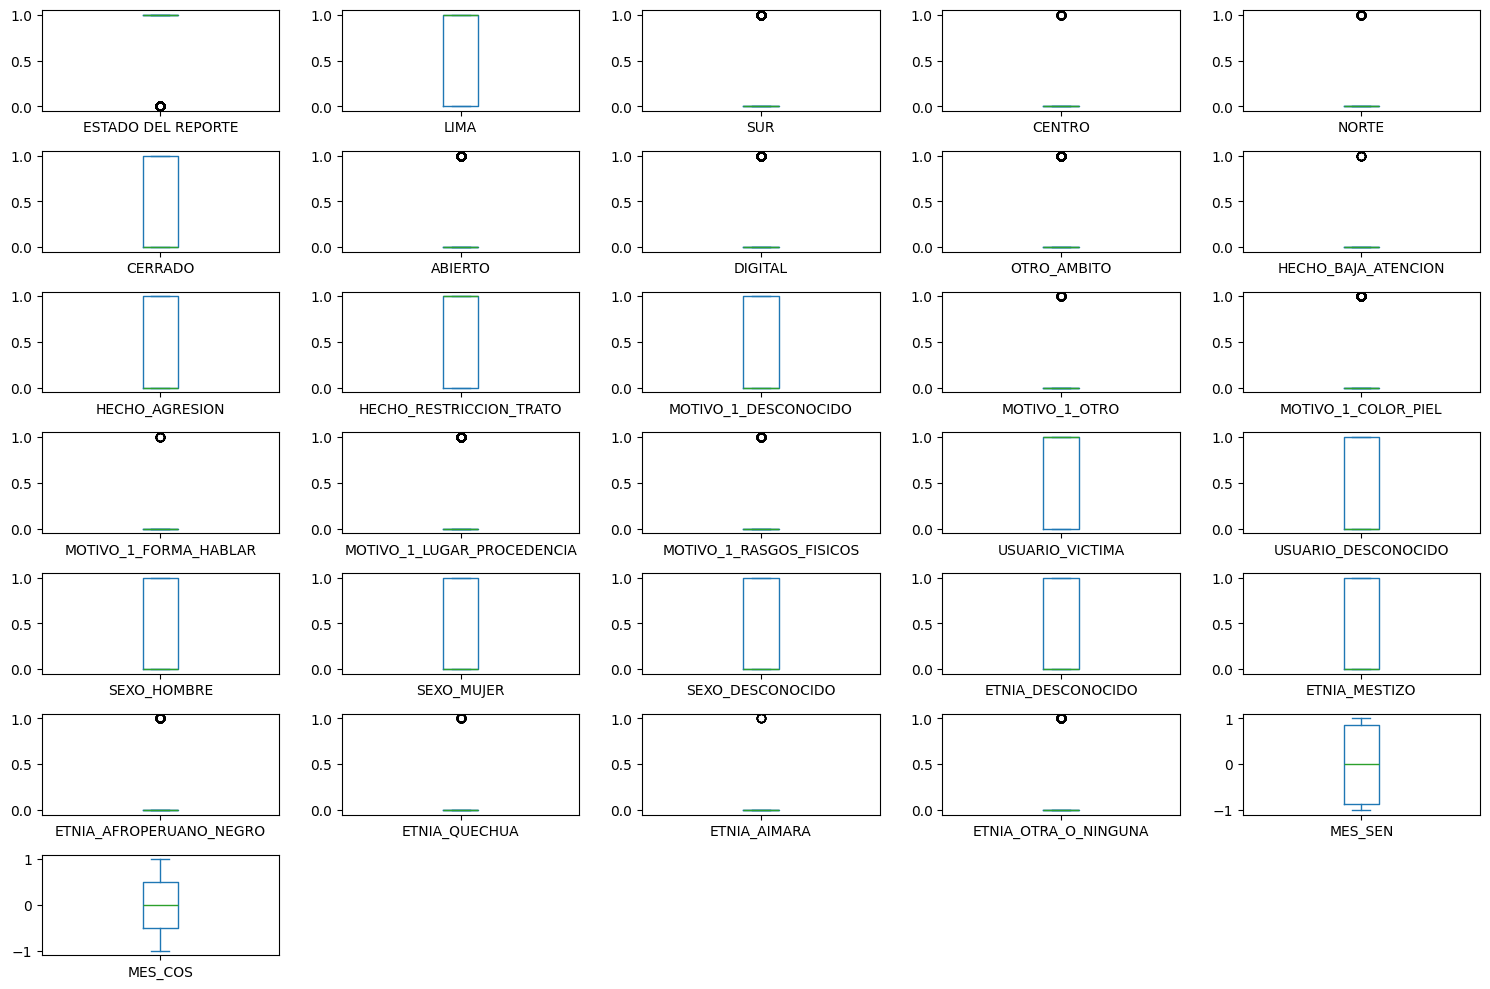

In [ ]:
import matplotlib.pyplot as plt
df.plot(kind='box', subplots=True, layout=(7, 5), sharex=True, sharey=False, figsize=(15, 10))
plt.tight_layout() # Para ajustar el espaciado y evitar superposiciones
plt.show()

In [ ]:
pd.set_option('display.precision', 2)  # setea la cantidad de decimales a mostrar en lo sucesivo en los dataframes

df_corr = df.corr(numeric_only=True).apply(lambda x: round(x, 2))

print("Matriz de Correlación (valores numéricos):")
print(df_corr.to_string())

Matriz de Correlación (valores numéricos):
                            ESTADO DEL REPORTE  LIMA   SUR  CENTRO  NORTE  CERRADO  ABIERTO  DIGITAL  OTRO_AMBITO  HECHO_BAJA_ATENCION  HECHO_AGRESION  HECHO_RESTRICCION_TRATO  MOTIVO_1_DESCONOCIDO  MOTIVO_1_OTRO  MOTIVO_1_COLOR_PIEL  MOTIVO_1_FORMA_HABLAR  MOTIVO_1_LUGAR_PROCEDENCIA  MOTIVO_1_RASGOS_FISICOS  USUARIO_VICTIMA  USUARIO_DESCONOCIDO  SEXO_HOMBRE  SEXO_MUJER  SEXO_DESCONOCIDO  ETNIA_DESCONOCIDO  ETNIA_MESTIZO  ETNIA_AFROPERUANO_NEGRO  ETNIA_QUECHUA  ETNIA_AIMARA  ETNIA_OTRA_O_NINGUNA  MES_SEN  MES_COS
ESTADO DEL REPORTE                        1.00  0.07 -0.05    0.02   0.00    -0.02     0.01    -0.00         0.02                -0.06           -0.05                     0.06                  0.36          -0.03                -0.25                  -0.08                       -0.13                    -0.06            -0.23                 0.29        -0.12       -0.16              0.25               0.19          -0.08              

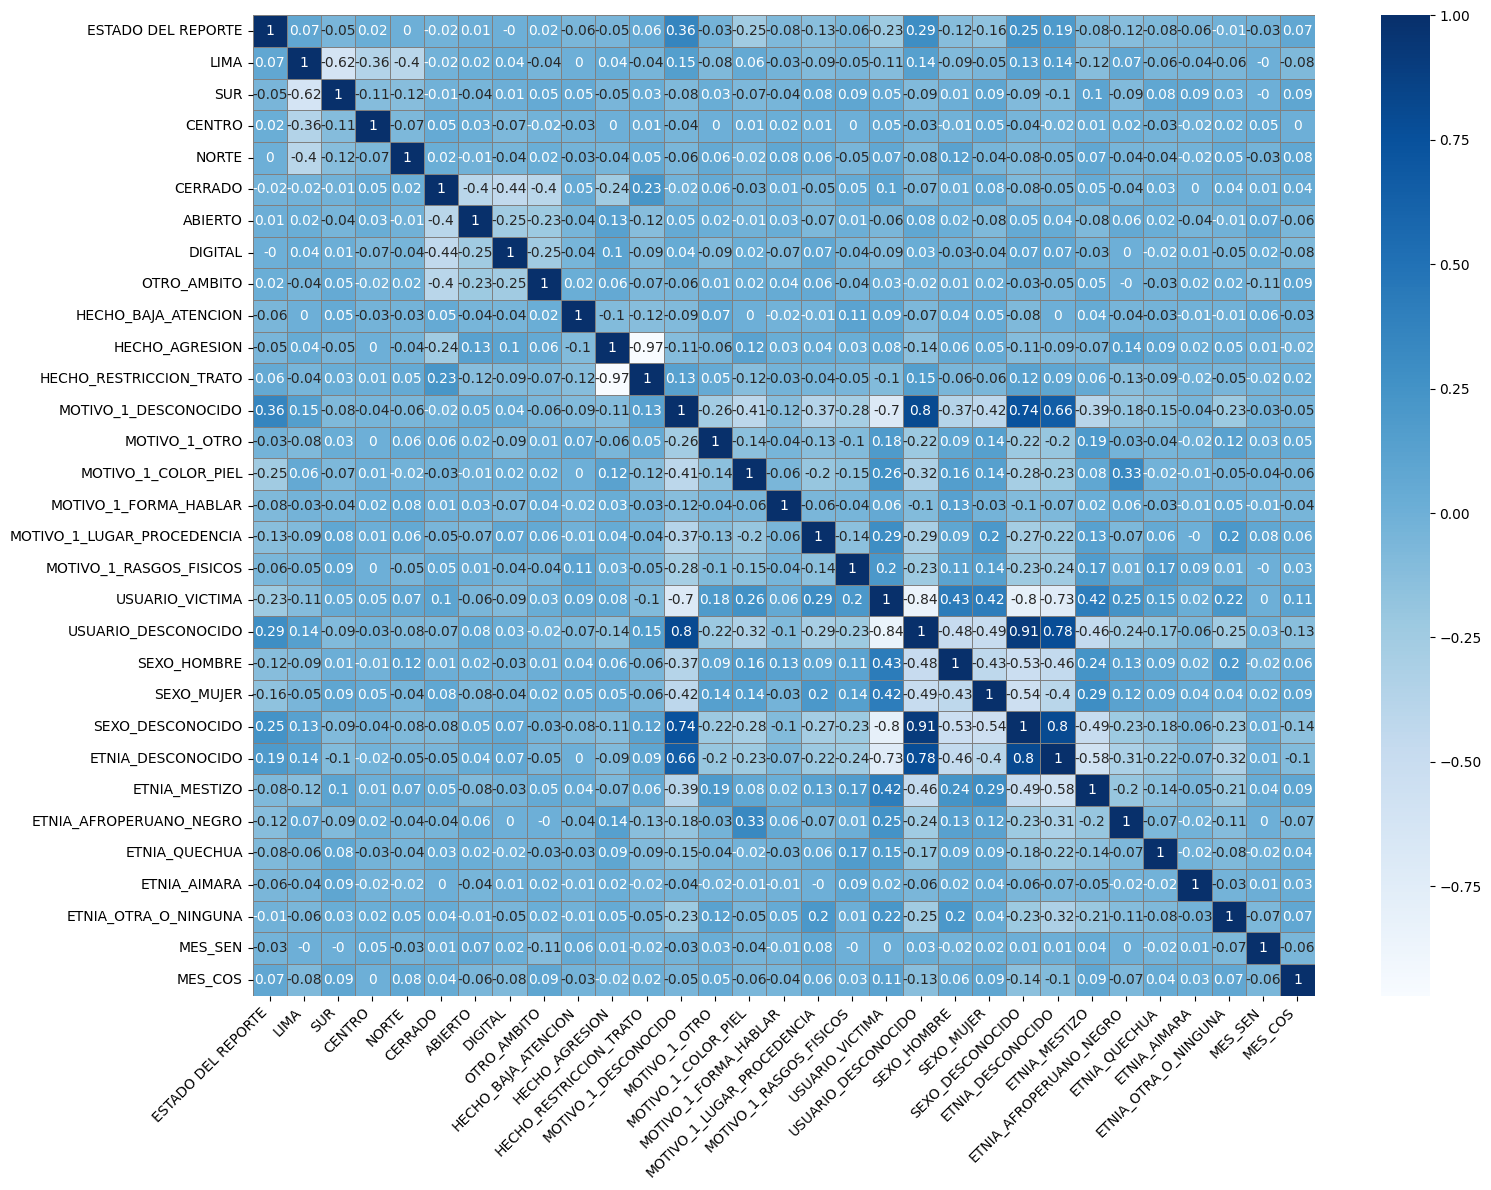

In [ ]:
import seaborn as sns

pd.set_option('display.precision', 2)  # setea la cantidad de decimales a mostrar en lo sucesivo en los dataframes
df_corr = df.corr(numeric_only=True).apply(lambda x: round(x, 2))

plt.figure(figsize=(16, 12))  # Aumenta el tamaño aquí
sns.heatmap(df_corr,
            annot=True,
            cmap='Blues',
            annot_kws={"size": 10},  # Tamaño del texto dentro del heatmap
            linewidths=0.5,  # Líneas entre cuadros
            linecolor='gray')

plt.xticks(rotation=45, ha='right')  # Gira las etiquetas del eje X
plt.yticks(rotation=0)
plt.tight_layout()  # Ajusta automáticamente los márgenes
plt.show()

In [ ]:
# Calcula la matriz de correlación y redondea a 2 decimales
df_corr = df.corr(numeric_only=True).apply(lambda x: round(x, 2))

# Imprime la matriz de correlación
print(df_corr)

                            ESTADO DEL REPORTE  LIMA   SUR  CENTRO  NORTE  CERRADO  ABIERTO  DIGITAL  OTRO_AMBITO  HECHO_BAJA_ATENCION  HECHO_AGRESION  HECHO_RESTRICCION_TRATO  MOTIVO_1_DESCONOCIDO  MOTIVO_1_OTRO  MOTIVO_1_COLOR_PIEL  MOTIVO_1_FORMA_HABLAR  MOTIVO_1_LUGAR_PROCEDENCIA  MOTIVO_1_RASGOS_FISICOS  USUARIO_VICTIMA  USUARIO_DESCONOCIDO  SEXO_HOMBRE  SEXO_MUJER  SEXO_DESCONOCIDO  ETNIA_DESCONOCIDO  ETNIA_MESTIZO  ETNIA_AFROPERUANO_NEGRO  ETNIA_QUECHUA  ETNIA_AIMARA  ETNIA_OTRA_O_NINGUNA  MES_SEN  MES_COS
ESTADO DEL REPORTE                        1.00  0.07 -0.05    0.02   0.00    -0.02     0.01    -0.00         0.02                -0.06           -0.05                     0.06                  0.36          -0.03                -0.25                  -0.08                       -0.13                    -0.06            -0.23                 0.29        -0.12       -0.16              0.25               0.19          -0.08                    -0.12          -0.08         -0.06   

In [ ]:
# Sacar columna y moverla al final
col = df.pop('ESTADO DEL REPORTE')
df['ESTADO DEL REPORTE'] = col

In [ ]:
# Cambiar las opciones para mostrar todas las filas y columnas
# Aumentar el ancho del display para que entren más columnas en una sola línea
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.expand_frame_repr', False)  # No dividir el DataFrame en varias líneas
pd.set_option('display.width', 1000)  # Aumentar el ancho total de impresión (ajusta según tu necesidad)

# Mostrar el DataFrame
print(df)

      LIMA  SUR  CENTRO  NORTE  CERRADO  ABIERTO  DIGITAL  OTRO_AMBITO  HECHO_BAJA_ATENCION  HECHO_AGRESION  HECHO_RESTRICCION_TRATO  MOTIVO_1_DESCONOCIDO  MOTIVO_1_OTRO  MOTIVO_1_COLOR_PIEL  MOTIVO_1_FORMA_HABLAR  MOTIVO_1_LUGAR_PROCEDENCIA  MOTIVO_1_RASGOS_FISICOS  USUARIO_VICTIMA  USUARIO_DESCONOCIDO  SEXO_HOMBRE  SEXO_MUJER  SEXO_DESCONOCIDO  ETNIA_DESCONOCIDO  ETNIA_MESTIZO  ETNIA_AFROPERUANO_NEGRO  ETNIA_QUECHUA  ETNIA_AIMARA  ETNIA_OTRA_O_NINGUNA  MES_SEN  MES_COS  ESTADO DEL REPORTE
0        0    0       1      0        1        0        0            0                    0               1                        0                     1              0                    0                      0                           0                        0                0                    1            0           0                 1                  1              0                        0              0             0                     0     0.87    -0.50                   1
1       

**FIN PREPROCESAMIENTO**

**INICIO ENTRENAMIENTO**

In [ ]:
import pandas as pd
import numpy as np

# --- 1. Verificar la distribución de clases ANTES del downsampling ---
print("--- Distribución de clases ANTES del downsampling (DataFrame Original) ---")
print(df['ESTADO DEL REPORTE'].value_counts())
print(f"Proporción de Clase 1 (Atendido): {df['ESTADO DEL REPORTE'].value_counts(normalize=True).get(1.0, 0):.4f}")
print(f"Proporción de Clase 0 (No Atendido): {df['ESTADO DEL REPORTE'].value_counts(normalize=True).get(0.0, 0):.4f}")
print("-" * 70)

# --- 2. Crear una COPIA del DataFrame original para aplicar el downsampling ---
df_copia = df.copy()

# --- 3. Aplicar el downsampling a la COPIA del DataFrame (frac=0.5) ---
# Filtrar las filas con ESTADO DEL REPORTE == 1 de la copia
estado_1_copia = df_copia[df_copia['ESTADO DEL REPORTE'] == 1]

# Filtrar las filas con ESTADO DEL REPORTE != 1 de la copia
estado_no_1_copia = df_copia[df_copia['ESTADO DEL REPORTE'] != 1]

# Seleccionar aleatoriamente la mitad de las filas con ESTADO DEL REPORTE == 1 de la copia
estado_1_reducido_copia = estado_1_copia.sample(frac=0.5, random_state=42) # random_state para reproducibilidad

# Combinar de nuevo y reiniciar índice en la copia
df_balanceado_frac_05 = pd.concat([estado_no_1_copia, estado_1_reducido_copia]).sample(frac=1, random_state=42).reset_index(drop=True)

# --- 4. Verificar la distribución de clases DESPUÉS del downsampling (en la copia) ---
print("\n--- Distribución de clases DESPUÉS del downsampling (frac=0.5 en copia) ---")
print(df_balanceado_frac_05['ESTADO DEL REPORTE'].value_counts())
print(f"Total de ejemplos en df_balanceado_frac_05: {len(df_balanceado_frac_05)}")
print(f"Proporción de Clase 1 (Atendido): {df_balanceado_frac_05['ESTADO DEL REPORTE'].value_counts(normalize=True).get(1.0, 0):.4f}")
print(f"Proporción de Clase 0 (No Atendido): {df_balanceado_frac_05['ESTADO DEL REPORTE'].value_counts(normalize=True).get(0.0, 0):.4f}")
print("-" * 70)

--- Distribución de clases ANTES del downsampling (DataFrame Original) ---
ESTADO DEL REPORTE
1    1073
0     179
Name: count, dtype: int64
Proporción de Clase 1 (Atendido): 0.8570
Proporción de Clase 0 (No Atendido): 0.1430
----------------------------------------------------------------------

--- Distribución de clases DESPUÉS del downsampling (frac=0.5 en copia) ---
ESTADO DEL REPORTE
1    536
0    179
Name: count, dtype: int64
Total de ejemplos en df_balanceado_frac_05: 715
Proporción de Clase 1 (Atendido): 0.7497
Proporción de Clase 0 (No Atendido): 0.2503
----------------------------------------------------------------------


In [ ]:
print('Actualmente tenemos un dataset de dimensiones {}'.format(df.shape))

Actualmente tenemos un dataset de dimensiones (1252, 31)


In [ ]:
df['ESTADO DEL REPORTE'].value_counts()

,count
ESTADO DEL REPORTE,
1,1073
0,179


In [ ]:
# Cargar libreriras y modulos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest   # para seleccionar atributos de forma univariada (filtros)
from sklearn.feature_selection import chi2   # estadististica para evaluar la importancia de atributos en relacion al target
from sklearn.feature_selection import RFE    # metodo recursive featute elimination
from sklearn.decomposition import PCA        # para transformacion PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # para modelos discriminantes lineales
from sklearn.naive_bayes import GaussianNB   # para modelos Naive Bayes
from sklearn.linear_model import LogisticRegression # para usar modelos de regresion logistica
from sklearn.tree import DecisionTreeClassifier     # para usar modelos de tipo arboles de decision
from sklearn.neighbors import KNeighborsClassifier  # para modelos  Knn
from sklearn.svm import SVC   # para modelos SVM

from sklearn.model_selection import train_test_split  # para partir los datos en conjuntos de entrenamiento y validacion
from sklearn.model_selection import KFold  # para partir la data en k-folds
from sklearn.model_selection import cross_val_score   # para evaluar algoritmos en cross validacion

from sklearn.metrics import accuracy_score, balanced_accuracy_score   # para manejar metricas de desempeño
from sklearn.metrics import classification_report  # para hacer reportes de resultados de clasificacion
from sklearn.metrics import confusion_matrix  # para manejar matrices de confusion
from sklearn.metrics import jaccard_score  # indice jacard
from sklearn.ensemble import RandomForestClassifier

# separa atributos del target
array = df.values
X = array[:,0:24]  #atributos
y = array[:,25]    #target

# realiza el train-test split
test_size = 0.20    # proporcion de muestras para validacion
seed = 7   # semilla para el generador aleatorio (para reproductibilidad)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

print('Training: %d ejemplos. Test: %d ejemplos' % (len(y_train), len(y_test)))

Training: 1001 ejemplos. Test: 251 ejemplos


In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter # Para contar las clases

# --- Verificar la distribución de clases en y_train (ANTES de SMOTE) ---
print("--- Distribución de clases en y_train (ANTES de SMOTE) ---")
print(Counter(y_train))
print(f"Proporción de Clase 1: {Counter(y_train).get(1.0, 0) / len(y_train):.4f}")
print(f"Proporción de Clase 0: {Counter(y_train).get(0.0, 0) / len(y_train):.4f}")
print("-" * 70)

print("\n--- Distribución de clases en y_test (NO se modificará con SMOTE) ---")
print(Counter(y_test))
print(f"Proporción de Clase 1: {Counter(y_test).get(1.0, 0) / len(y_test):.4f}")
print(f"Proporción de Clase 0: {Counter(y_test).get(0.0, 0) / len(y_test):.4f}")
print("-" * 70)


# --- Aplicar SMOTE al conjunto de entrenamiento (X_train, y_train) ---
print("\n--- Aplicando SMOTE para balancear el conjunto de entrenamiento ---")
sm = SMOTE(random_state=seed) # Reusa la misma semilla para reproducibilidad
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# --- Verificar la distribución de clases DESPUÉS de SMOTE en el conjunto de entrenamiento ---
print("\n--- Distribución de clases en y_train_resampled (DESPUÉS de SMOTE) ---")
print(Counter(y_train_resampled))
print(f"Proporción de Clase 1: {Counter(y_train_resampled).get(1.0, 0) / len(y_train_resampled):.4f}")
print(f"Proporción de Clase 0: {Counter(y_train_resampled).get(0.0, 0) / len(y_train_resampled):.4f}")
print("-" * 70)

print("\nSMOTE aplicado exitosamente. Ahora X_train_resampled y y_train_resampled están balanceados.")
print("Puedes usar estos conjuntos para entrenar tus modelos, y X_test, y_test para evaluarlos.")

--- Distribución de clases en y_train (ANTES de SMOTE) ---
Counter({np.float64(0.0): 951, np.float64(1.0): 50})
Proporción de Clase 1: 0.0500
Proporción de Clase 0: 0.9500
----------------------------------------------------------------------

--- Distribución de clases en y_test (NO se modificará con SMOTE) ---
Counter({np.float64(0.0): 239, np.float64(1.0): 12})
Proporción de Clase 1: 0.0478
Proporción de Clase 0: 0.9522
----------------------------------------------------------------------

--- Aplicando SMOTE para balancear el conjunto de entrenamiento ---

--- Distribución de clases en y_train_resampled (DESPUÉS de SMOTE) ---
Counter({np.float64(0.0): 951, np.float64(1.0): 951})
Proporción de Clase 1: 0.5000
Proporción de Clase 0: 0.5000
----------------------------------------------------------------------

SMOTE aplicado exitosamente. Ahora X_train_resampled y y_train_resampled están balanceados.
Puedes usar estos conjuntos para entrenar tus modelos, y X_test, y_test para evalua

LogReg: 0.9154 (0.0191)
5NN: 0.9106 (0.0210)
10NN: 0.8854 (0.0181)
CART_none: 0.9711 (0.0147)
CART_20: 0.9700 (0.0151)
CART_5: 0.9343 (0.0141)
SVM: 0.9627 (0.0124)
NB: 0.8964 (0.0206)
LDA: 0.8985 (0.0183)
RF_100: 0.9758 (0.0167)


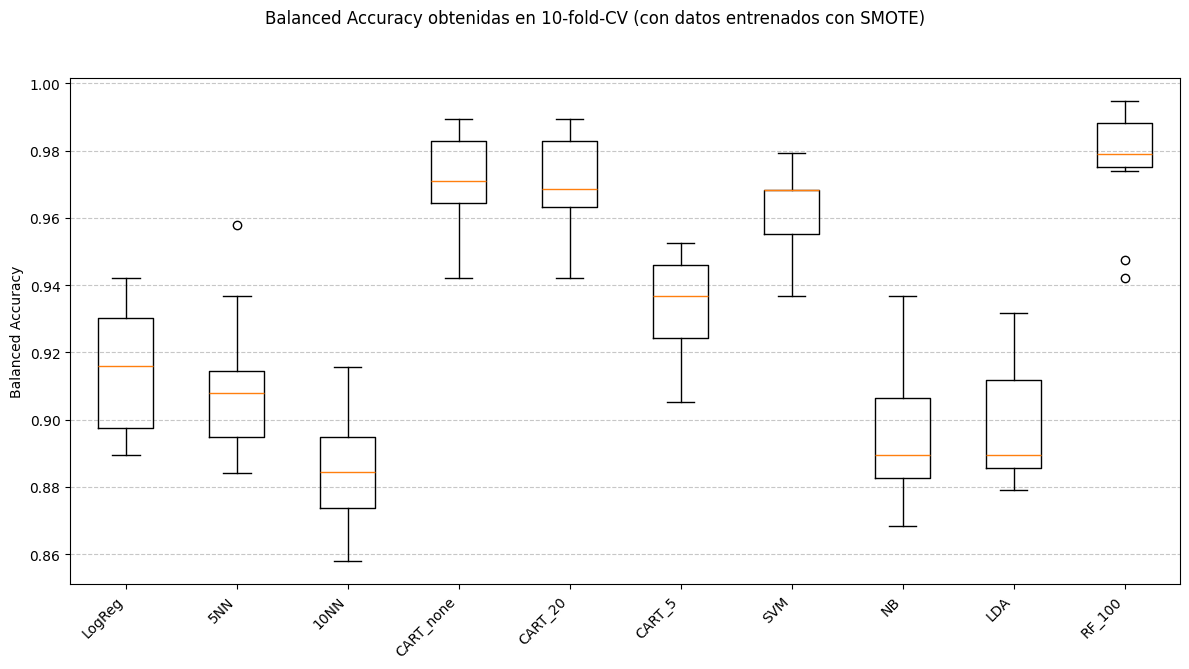

In [ ]:
# Definimos el pool de algoritmos de ML a evaluar
algos = []
algos.append(('LogReg',     LogisticRegression(solver='liblinear')))
algos.append(('5NN',        KNeighborsClassifier(n_neighbors=5)))
algos.append(('10NN',       KNeighborsClassifier(n_neighbors=10)))
algos.append(('CART_none',  DecisionTreeClassifier(max_depth=None)))
algos.append(('CART_20',    DecisionTreeClassifier(max_depth=20)))
algos.append(('CART_5',     DecisionTreeClassifier(max_depth=5)))       # árbol muy podado
algos.append(('SVM',        SVC(class_weight='balanced'))) # Mantener class_weight='balanced' para SVM, ya que lo soporta y ayuda con el desbalance.
algos.append(('NB',         GaussianNB()))                                # Naive Bayes gaussiano
algos.append(('LDA',        LinearDiscriminantAnalysis()))                # Análisis discriminante lineal
algos.append(('RF_100',     RandomForestClassifier(n_estimators=100, random_state=seed))) # Bosque aleatorio

# Evaluamos cada algoritmo de ML en estrategia de 10-fold-CV
results = []
names = []

from sklearn.model_selection import StratifiedKFold

seed = 7
# kfold usará StratifiedKFold para asegurar que cada fold de validación cruzada
# tenga una proporción de clases similar a la de y_train_resampled.
kfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)

# evalúa cada algoritmo de ML usando los datos balanceados por SMOTE
for algoname, algo in algos:
    # --- CAMBIO CLAVE AQUÍ: Usamos X_train_resampled y y_train_resampled ---
    cv_results = cross_val_score(algo, X_train_resampled, y_train_resampled, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(algoname)
    print("{}: {:.4f} ({:.4f})".format(algoname, cv_results.mean(), cv_results.std()))

# Muestra graficamente los resultados de balanced_accuracy en crossvalidacion de los Algoritmos evaluados
fig = plt.figure(figsize=(12, 7)) # Aumenta el tamaño para mejor visualización
fig.suptitle('Balanced Accuracy obtenidas en 10-fold-CV (con datos entrenados con SMOTE)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=45, ha='right') # Rota etiquetas si son largas
plt.ylabel('Balanced Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta el layout para que el título no se superponga
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report

# --- Reentrenar el modelo LogisticRegression con TODOS los datos de entrenamiento balanceados por SMOTE ---
# Añadimos class_weight='balanced' para que el modelo se enfoque en la clase minoritaria.
model_logreg = LogisticRegression(solver='liblinear', random_state=seed, class_weight='balanced')

# Entrenar con los datos RESAMPLEADOS (balanceados por SMOTE)
model_logreg.fit(X_train_resampled, y_train_resampled)

# --- Obtener las probabilidades para la clase 1 en el conjunto de PRUEBA (X_test) ORIGINAL ---
y_proba_positive_logreg = model_logreg.predict_proba(X_test)[:, 1]

# --- Aplicar el umbral de 0.6 para predecir las clases ---
umbral_elegido = 0.6
y_predicted_logreg_umbral = (y_proba_positive_logreg >= umbral_elegido).astype(int)


# --- Evalúa el rendimiento final de LogisticRegression con el umbral de 0.6 ---
print(f"--- Evaluación Final del Modelo LogisticRegression (Umbral {umbral_elegido:.1f}) en el Conjunto de Prueba Original ---")
print("Balanced Accuracy score en el conjunto de prueba:", balanced_accuracy_score(y_test, y_predicted_logreg_umbral))

# Muestra la matriz de confusión
print("\nMatriz de Confusión en el conjunto de prueba:")
print(confusion_matrix(y_test, y_predicted_logreg_umbral))

# Muestra un reporte de la clasificación en el conjunto de prueba
print("\nReporte de clasificación en conjunto de prueba: \n")
print(classification_report(y_test, y_predicted_logreg_umbral, zero_division=0)) # zero_division=0 para evitar warnings si una clase no tiene predicciones

--- Evaluación Final del Modelo LogisticRegression (Umbral 0.6) en el Conjunto de Prueba Original ---
Balanced Accuracy score en el conjunto de prueba: 0.9288702928870293

Matriz de Confusión en el conjunto de prueba:
[[205  34]
 [  0  12]]

Reporte de clasificación en conjunto de prueba: 

              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92       239
         1.0       0.26      1.00      0.41        12

    accuracy                           0.86       251
   macro avg       0.63      0.93      0.67       251
weighted avg       0.96      0.86      0.90       251



In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA # Aunque PCA no se usa en los pipelines que definiste, es importado aquí

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Definimos el pool de pipleines de ML (MinMaxScaler + algoritmo de ML) a evaluar
pipelines = []
pipelines.append(('LogReg', make_pipeline(MinMaxScaler(), LogisticRegression(solver='liblinear', random_state=7))))
pipelines.append(('5NN', make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=5))))
pipelines.append(('10NN', make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=10))))
pipelines.append(('CART', make_pipeline(MinMaxScaler(), DecisionTreeClassifier(max_depth=None, random_state=7))))
pipelines.append(('SVM', make_pipeline(MinMaxScaler(), SVC(random_state=7))))

In [ ]:
# Evaluamos cada pipeline de ML en estrategia de 10-fold-CV
results = []
names = []

# genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 7
kfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)  # especifica el particionador de datos a 10-folds CV

#  evalua cada pipeline en crosvalidacion
for pipelinename, pipeline in pipelines:
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(pipelinename)
    print("{}: {} ({})".format(pipelinename, cv_results.mean(), cv_results.std()))

LogReg: 0.5278947368421052 (0.046187021956713294)
5NN: 0.5979057017543858 (0.10252131355945748)
10NN: 0.49947368421052635 (0.0015789473684210576)
CART: 0.726858552631579 (0.1322674840529238)
SVM: 0.5089473684210526 (0.030421781087617734)


In [ ]:
# --- 1. Definir y entrenar el pipeline completo con TODOS los datos de entrenamiento ORIGINALES ---
# Este pipeline encapsula todo el flujo de trabajo: escalado, SMOTE y el clasificador.
final_logreg_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state=seed)),
    ('classifier', LogisticRegression(solver='liblinear', random_state=seed, class_weight='balanced'))
])

print("Entrenando el pipeline final en los datos de entrenamiento originales (X_train, y_train)...")
final_logreg_pipeline.fit(X_train, y_train)
print("Entrenamiento completado.")

# --- 2. Obtener las probabilidades de predicción para la Clase 1 en el conjunto de PRUEBA ORIGINAL ---
# El pipeline se encarga automáticamente del escalado en X_test.
y_proba_positive_pipeline = final_logreg_pipeline.predict_proba(X_test)[:, 1]

# --- 3. Aplicar el umbral de 0.6 para predecir las clases ---
umbral_elegido = 0.6
y_predicted_pipeline_umbral = (y_proba_positive_pipeline >= umbral_elegido).astype(int)

# --- 4. Evaluar el rendimiento final del Pipeline en el conjunto de prueba ---
print(f"\n--- Evaluación Final del Pipeline LogisticRegression (Umbral {umbral_elegido:.1f}) en el Conjunto de Prueba Original ---")

print("Balanced Accuracy score en el conjunto de prueba:", balanced_accuracy_score(y_test, y_predicted_pipeline_umbral))

print("\nMatriz de Confusión en el conjunto de prueba:")
print(confusion_matrix(y_test, y_predicted_pipeline_umbral))

print("\nReporte de clasificación en conjunto de prueba: \n")
print(classification_report(y_test, y_predicted_pipeline_umbral, zero_division=0))

Entrenando el pipeline final en los datos de entrenamiento originales (X_train, y_train)...
Entrenamiento completado.

--- Evaluación Final del Pipeline LogisticRegression (Umbral 0.6) en el Conjunto de Prueba Original ---
Balanced Accuracy score en el conjunto de prueba: 0.9288702928870293

Matriz de Confusión en el conjunto de prueba:
[[205  34]
 [  0  12]]

Reporte de clasificación en conjunto de prueba: 

              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92       239
         1.0       0.26      1.00      0.41        12

    accuracy                           0.86       251
   macro avg       0.63      0.93      0.67       251
weighted avg       0.96      0.86      0.90       251



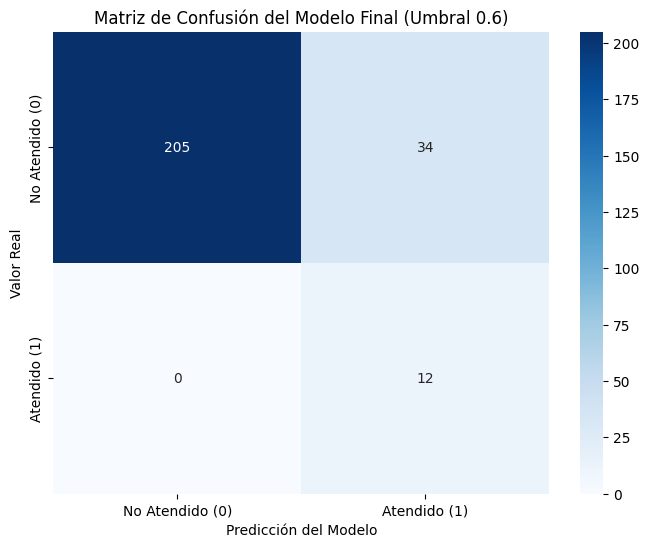

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_predicted_pipeline_umbral)
labels = ['No Atendido (0)', 'Atendido (1)']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción del Modelo')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión del Modelo Final (Umbral 0.6)')
plt.show()

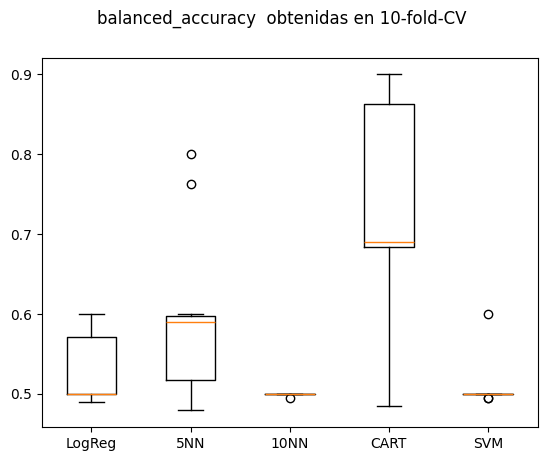

In [ ]:
fig = plt.figure()
fig.suptitle('balanced_accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()